In [21]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


In [22]:
elev = rasterio.open('t47_dem.tif')
slope = rasterio.open('t47_slope.tif')
dinf = rasterio.open('t47_acc.tif')

evel_data=elev.read(1, masked=True)
slope_data=slope.read(1, masked=True)
dinf_data=dinf.read(1, masked=True)

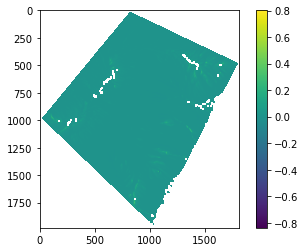

In [31]:
plt.imshow(q_cr)
plt.colorbar()

In [23]:
slope_normal_soil_thickness = np.cos(np.radians(slope_data))

a = dinf_data; #flow accumulation [m^2] (flow acc currently in pixels,
#would mutliply by 2 for drainage area in m2 since 2m DEM but since
#'b' is length of countour also 2 m, they cancel out)

In [24]:
q_aug = .08; #[m/day] rain Aug 2 2020
z = 1; #active layer thickness, [m]
tanphi = .84; # tan (40 degrees) i think??? internal angle of friction
s_w_dens = 2; #ratio of density of saturated soil to water 
Ksat_maybe = 2.2; #m/day if 1/3 is organic and 2/3 is mineral 

In [25]:

q_cr_T = ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi));
#critical rainfall / transmissivity

q_cr_K = ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness;
#critical rainfall / hydraulic conductivity [T = K cos(theta) z]

k_aug_crit = q_aug / ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a )* (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness;
#hydraulic conductivity that just crosses failure threshold for Aug 2
#rainfall event

q_cr= ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness * Ksat_maybe;


Text(0.5, 1.05, 'min Ksat (m/day) to prevent failure for Aug 2 rainfall')

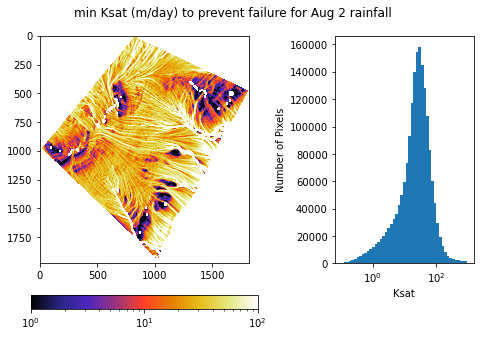

In [46]:
from matplotlib import gridspec
fig, ax = plt.subplots(1,2,figsize=(7,4),
                       gridspec_kw={
                           'width_ratios': [2, 1]})
#mm/day rainfall for failure
map = ax[0].imshow(k_aug_crit, cmap='CMRmap', norm=LogNorm(vmin=1E0, vmax=1E2))
#ax[0].colorbar()
ax[1].hist(k_aug_crit.flatten(),bins=np.logspace(-1,3))
ax[1].set_xscale('log')
ax[1].set_xlabel('Ksat')
ax[1].set_ylabel('Number of Pixels')
# plt.subplots_adjust(right=1.6)
fig.tight_layout()
cbar_ax = fig.add_axes([0.1, 0, 0.45, 0.05])
fig.colorbar(map,cax=cbar_ax,orientation="horizontal")
fig.suptitle('min Ksat (m/day) to prevent failure for Aug 2 rainfall',y=1.05)

#plt.xlim(0,3)

In [38]:
#slopes - between 14 and 20
#DA - between 0 and 2000
pts=20
slope_array=np.linspace(12,20,num=pts)
da_array=np.geomspace(1e1,1e4,num=pts)
slope_normal_array = np.cos(np.radians(slope_array))
k_aug_crit_matrix=np.zeros((pts,pts))

for i in range(len(slope_array)):
    for j in range(len(da_array)):
        k_aug_crit_matrix[i,j] = q_aug / ((np.sin(np.radians(slope_array[i])) *
                       (s_w_dens)) / da_array[j] )* (1 -  (np.tan(np.radians(slope_array[i])) / tanphi)) * z * slope_normal_array[i];


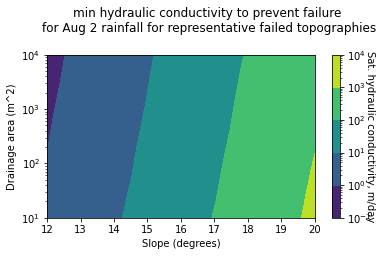

In [39]:

from matplotlib import ticker, cm
fig, ax = plt.subplots(figsize=(6,3))
CS = ax.contourf(slope_array,da_array,k_aug_crit_matrix,locator=ticker.LogLocator())
#ax.clabel(CS, inline=1)
ax.set_yscale('log')
cbar = fig.colorbar(CS)
fig.suptitle('min hydraulic conductivity to prevent failure \nfor Aug 2 rainfall for representative failed topographies',y=1.1)
plt.xlabel('Slope (degrees)')
plt.ylabel('Drainage area (m^2)')
cbar.set_label('Sat. hydraulic conductivity, m/day', rotation=270)